
# Data and computations for paper 

Lars G. Johnsen
National Library of Norway

In [1]:
import dhlab.nbtext as nb
import dhlab.module_update as mu
mu.update('collocations')
from collocations import dist_coll_urn, urn_coll, calculate_midpoint, dist
import pandas as pd

Updated file `C:\Users\yoons\Documents\GitHub\newspapers_coll_conc\collocations.py`

In [135]:
movealpha = lambda x: list(tuple([x[-1]]) + tuple(x[:-1]))

In [2]:
def df_jaccard(df, col1, col2, number=100, asc=False):
    s1 = df.sort_values(by=col1, ascending=asc)[:number].index
    s2 = df.sort_values(by=col2, ascending=asc)[:number].index
    
    #print(len(set(s1)&set(s2)))
    
    return jaccard(s1, s2)

In [3]:
def jaccards(s1, s2):
    return len(set(s1)&set(s2)),len(set(s1)|set(s2))

In [4]:
def jaccard(s1, s2):
    return len(set(s1)&set(s2))/len(set(s1)|set(s2))

In [5]:
def large_corpus_dist_coll(collword, urns = None, after= 10, before = 0, n = 300):
    colls_freq = []
    colls_dist = []
    coll = pd.DataFrame()
    for i in range(0, len(urns), n):
        a = urn_coll(collword, urns = urns[i:i + n], after= after, before = before)
        colls_freq.append(nb.frame(a['freq']))
        colls_dist.append(nb.frame(a['dist']))
    coll['freq'] = pd.concat(colls_freq, axis=1, sort=False).sum(axis=1)
    coll['dist'] = pd.concat(colls_dist, axis = 1, sort=False).mean(axis=1)
    coll['dist_score'] = round(dist(coll['dist'], calculate_midpoint(before, after), coll['freq']), 2)
    return coll

In [6]:
def large_corpus_coll(collword, urns = None, after= 5, before = 5, n = 300):
    colls = []
    for i in range(0, len(urns), n):
        colls.append(nb.urn_coll(collword, urns=urns[i:i + n], after= after, before = before))
    coll = pd.concat(colls, axis=1, sort=False).sum(axis=1)
    return pd.DataFrame(coll)

In [97]:
def make_coll_df(small, large, tot):
    """take two collocations, small and large, and a reference tot. The reference must av a column call tot as well"""
    coll = pd.DataFrame()
    small = small[~small.reindex().duplicated()]
    large = large[~large.reindex().duplicated()]
    coll['small'] = small['freq'].astype(int)
    coll['large'] = large['freq'].astype(int)
    #coll['ratio'] = coll['small']/coll['large']
    coll['srel'] = coll.small/coll.small.sum()
    coll['lrel'] = coll.large/coll.large.sum()
    coll['ratio'] = coll.srel/coll.lrel
    coll['adjusted'] = coll.small**0.01*coll.ratio
    coll['ref-small'] = coll.srel/tot.tot
    coll['ref-large'] = coll.lrel/tot.tot
    coll = coll.fillna(0)
    return coll.astype({'small':'int32', 'large':'int32'})

### Reference corpus

The reference is the total counts from approximately 450 000 books from nb.no

In [9]:
tot = nb.frame(nb.totals(50000), 'tot')

In [10]:
nb.normalize_corpus_dataframe(tot)
tot.head()

,tot
.,0.058921
",",0.051453
og,0.025297
i,0.021425
det,0.012728


# Corpus

The corpus for doing collocations is a sample of 800 books from fictional literature, dewey decimal code 813.

In [11]:
smd = 5
lmd = 10
collword = 'skrive'

In [12]:
def filenames(smd = smd, lmd = lmd, collword = collword, corpus_size= 1000, period = (1980, 2000)):
    return {
    'small_right': '_'.join([collword, str(smd), str(corpus_size), '-'.join([str(x) for x in period]), str(0), str(int(2*smd)), '.csv']),
    'large_right': '_'.join([collword, str(smd), str(corpus_size),  '-'.join([str(x) for x in period]), str(0), str(int(2*lmd)), '.csv']),
    'small_left' : '_'.join([collword, str(lmd), str(corpus_size),  '-'.join([str(x) for x in period]), str(int(2*smd)), str(0), '.csv']),
    'large_left' : '_'.join([collword, str(lmd), str(corpus_size),  '-'.join([str(x) for x in period]), str(int(2*lmd)), str(0), '.csv'])
        }

In [13]:
names = filenames(smd=smd, lmd=lmd, collword=collword)
names

{'small_right': 'skrive_5_1000_1980-2000_0_10_.csv',
 'large_right': 'skrive_5_1000_1980-2000_0_20_.csv',
 'small_left': 'skrive_10_1000_1980-2000_10_0_.csv',
 'large_left': 'skrive_10_1000_1980-2000_20_0_.csv'}

In [14]:
a1 = pd.read_csv(names['small_right'], index_col=0)
a2 = pd.read_csv(names['large_right'], index_col=0)
b1 = pd.read_csv(names['small_left'], index_col=0)
b2 = pd.read_csv(names['large_left'], index_col=0)

Set up the distance parameters and collword, smd is small distance while lmd is large distance. These values are half of the actual window, and used to make a normalized score, call ascore. See below.

## Create collocation dataframe 

Based on data from a1 and a2, and b1 and b2. The name for the collocations after is `coll` while `collb` is for the collocates coming before.

In [98]:
coll = make_coll_df(a1, a2, tot)
collb = make_coll_df(b1, b2, tot)

## Sorting 

Sorting on the reference is by column 'nb'

In [99]:
coll[coll.small < coll.large].sort_values(by='ratio', ascending=False)[:20][:20].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,ref-small,ref-large
lapp,18,19,0.000340,0.000187,1.817571,1.870872,64.787891,35.645309
testamente,13,14,0.000246,0.000138,1.781508,1.827794,29.816425,16.736618
erklæring,11,12,0.000208,0.000118,1.758669,1.801349,26.322659,14.967379
sammendrag,11,12,0.000208,0.000118,1.758669,1.801349,65.027200,36.975245
tale,11,12,0.000208,0.000118,1.758669,1.801349,1.859725,1.057462
dagbok,32,35,0.000605,0.000345,1.754101,1.815959,108.417797,61.808199
skuespill,10,11,0.000189,0.000108,1.744134,1.784760,24.268350,13.914268
ker,10,11,0.000189,0.000108,1.744134,1.784760,11.817794,6.775737
artikkel,56,62,0.001059,0.000611,1.732882,1.804059,30.927411,17.847388
redigere,9,10,0.000170,0.000099,1.726693,1.765052,75.637721,43.804968


In [147]:
coll = coll.drop('ker')

In [148]:
coll[coll.small < coll.large].sort_values(by='adjusted', ascending=False)[:20].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,ref-small,ref-large
lapp,18,19,0.000340,0.000187,1.817571,1.870872,64.787891,35.645309
testamente,13,14,0.000246,0.000138,1.781508,1.827794,29.816425,16.736618
dagbok,32,35,0.000605,0.000345,1.754101,1.815959,108.417797,61.808199
artikkel,56,62,0.001059,0.000611,1.732882,1.804059,30.927411,17.847388
erklæring,11,12,0.000208,0.000118,1.758669,1.801349,26.322659,14.967379
sammendrag,11,12,0.000208,0.000118,1.758669,1.801349,65.027200,36.975245
tale,11,12,0.000208,0.000118,1.758669,1.801349,1.859725,1.057462
skuespill,10,11,0.000189,0.000108,1.744134,1.784760,24.268350,13.914268
ned,313,360,0.005917,0.003547,1.668070,1.766729,9.258383,5.550355
redigere,9,10,0.000170,0.000099,1.726693,1.765052,75.637721,43.804968


In [149]:
coll[coll.small < coll.large].sort_values(by='ratio', ascending=False)[:20].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,ref-small,ref-large
lapp,18,19,0.000340,0.000187,1.817571,1.870872,64.787891,35.645309
testamente,13,14,0.000246,0.000138,1.781508,1.827794,29.816425,16.736618
erklæring,11,12,0.000208,0.000118,1.758669,1.801349,26.322659,14.967379
tale,11,12,0.000208,0.000118,1.758669,1.801349,1.859725,1.057462
sammendrag,11,12,0.000208,0.000118,1.758669,1.801349,65.027200,36.975245
dagbok,32,35,0.000605,0.000345,1.754101,1.815959,108.417797,61.808199
skuespill,10,11,0.000189,0.000108,1.744134,1.784760,24.268350,13.914268
artikkel,56,62,0.001059,0.000611,1.732882,1.804059,30.927411,17.847388
redigere,9,10,0.000170,0.000099,1.726693,1.765052,75.637721,43.804968
innlegg,8,9,0.000151,0.000089,1.705376,1.741209,17.801001,10.438171


In [105]:
common = coll.loc[[',','.', 'og','eller', 'i', 'på']]

In [106]:
common['translate'] = [',', '.', 'and', 'or', 'in', 'on']

In [130]:
common = common[list(tuple([common.columns[-1]]) + tuple(common.columns[:-1]))]

In [134]:
common[['translate', 'srel', 'ratio', 'ref-small']]

,translate,srel,ratio,ref-small
",",",",0.050074,0.987992,0.973187
.,.,0.071018,0.999720,1.205309
og,and,0.031587,0.957841,1.248611
eller,or,0.006465,1.123533,2.354717
i,in,0.023345,0.921231,1.089614
på,on,0.020415,1.060405,2.128986


# collb

In [150]:
collb[collb.small < collb.large].sort_values(by='adjusted', ascending=False)[:40].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,ref-small,ref-large
bedt,41,43,0.000750,0.000417,1.796513,1.864482,23.224493,12.927539
Kunne,13,14,0.000238,0.000136,1.749566,1.795022,12.824190,7.329927
voksne,96,106,0.001755,0.001029,1.706398,1.786089,31.615362,18.527543
Skal,19,21,0.000347,0.000204,1.704705,1.755645,5.451334,3.197817
fil,10,11,0.000183,0.000107,1.712862,1.752759,16.388741,9.568047
beregne,10,11,0.000183,0.000107,1.712862,1.752759,11.540282,6.737428
lese,378,435,0.006911,0.004221,1.637259,1.737370,93.945510,57.379733
meningen,9,10,0.000165,0.000097,1.695733,1.733404,8.940741,5.272493
vansker,9,10,0.000165,0.000097,1.695733,1.733404,13.969241,8.237878
111,9,10,0.000165,0.000097,1.695733,1.733404,1.650114,0.973098


In [56]:
collb.sort_values(by='nb', ascending=False)[:40].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,nb
Skrive,13,20,0.000238,0.000194,1.224696,1.256515,6279776.692557
tekstbehandling,7,10,0.000128,0.000097,1.318903,1.344819,5372527.357247
lese,378,435,0.006911,0.004221,1.637259,1.737370,5138725.457044
Lese,5,5,0.000091,0.000049,1.884148,1.914717,4954030.461233
startes,10,10,0.000183,0.000097,1.884148,1.928035,4898227.582543
Styre,5,6,0.000091,0.000058,1.570123,1.595598,3981035.375463
skriveren,9,12,0.000165,0.000116,1.413111,1.444504,3901658.903253
tastaturet,8,12,0.000146,0.000116,1.256099,1.282492,3805348.311331
Utskrift,6,9,0.000110,0.000087,1.256099,1.278808,3644873.064759
taster,5,8,0.000091,0.000078,1.177592,1.196698,3265981.525527


# coll

In [152]:
coll[coll.small < coll.large].sort_values(by='ratio', ascending=False)[:30].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,ref-small,ref-large
lapp,18,19,0.000340,0.000187,1.817571,1.870872,64.787891,35.645309
testamente,13,14,0.000246,0.000138,1.781508,1.827794,29.816425,16.736618
erklæring,11,12,0.000208,0.000118,1.758669,1.801349,26.322659,14.967379
tale,11,12,0.000208,0.000118,1.758669,1.801349,1.859725,1.057462
sammendrag,11,12,0.000208,0.000118,1.758669,1.801349,65.027200,36.975245
dagbok,32,35,0.000605,0.000345,1.754101,1.815959,108.417797,61.808199
skuespill,10,11,0.000189,0.000108,1.744134,1.784760,24.268350,13.914268
artikkel,56,62,0.001059,0.000611,1.732882,1.804059,30.927411,17.847388
redigere,9,10,0.000170,0.000099,1.726693,1.765052,75.637721,43.804968
innlegg,8,9,0.000151,0.000089,1.705376,1.741209,17.801001,10.438171


In [154]:
coll.sort_values(by='ref-small', ascending=False)[:30].fillna(0).style.background_gradient()

,small,large,srel,lrel,ratio,adjusted,ref-small,ref-large
resept,15,15,0.000284,0.000148,1.918548,1.971213,142.266072,74.153010
diktat,7,9,0.000132,0.000089,1.492204,1.521525,125.934037,84.394674
stiler,10,14,0.000189,0.000138,1.370391,1.402312,124.843297,91.100489
memoarer,8,11,0.000151,0.000108,1.395307,1.424626,122.780348,87.995204
selvbiografi,7,7,0.000132,0.000069,1.918548,1.956246,111.538893,58.137155
dagbok,32,35,0.000605,0.000345,1.754101,1.815959,108.417797,61.808199
låter,14,16,0.000265,0.000158,1.678729,1.723621,100.714210,59.994321
tastaturet,10,19,0.000189,0.000187,1.009762,1.033282,89.915039,89.045788
skrivemaskin,7,13,0.000132,0.000128,1.033064,1.053363,88.283292,85.457715
redigere,9,10,0.000170,0.000099,1.726693,1.765052,75.637721,43.804968


# top 10 for translation

In [166]:
top10ratio = coll[coll.small < coll.large].sort_values(by='ratio', ascending=False)[:10]
top10ref = coll[coll.small < coll.large].sort_values(by='ref-large', ascending=False)[:10]

In [156]:
top10ratio.index


Index(['lapp', 'testamente', 'erklæring', 'tale', 'sammendrag', 'dagbok',
       'skuespill', 'artikkel', 'redigere', 'innlegg'],
      dtype='object')

In [157]:
top10ratio['trans'] = ['note', 'wills', 'statement', 'speech', 'summary', 'diary',
       'play', 'article', 'edit', 'post']

In [158]:
top10ratio = top10ratio[movealpha(top10ratio.columns)]

In [159]:
top10ratio[['trans', 'srel', 'ratio', 'ref-large']]

,trans,srel,ratio,ref-large
lapp,note,0.000340,1.817571,35.645309
testamente,wills,0.000246,1.781508,16.736618
erklæring,statement,0.000208,1.758669,14.967379
tale,speech,0.000208,1.758669,1.057462
sammendrag,summary,0.000208,1.758669,36.975245
dagbok,diary,0.000605,1.754101,61.808199
skuespill,play,0.000189,1.744134,13.914268
artikkel,article,0.001059,1.732882,17.847388
redigere,edit,0.000170,1.726693,43.804968
innlegg,post,0.000151,1.705376,10.438171


In [167]:
top10ref.index

Index(['stiler', 'tastaturet', 'memoarer', 'skrivemaskin', 'diktat', 'dagbok',
       'låter', 'reserverte', 'markøren', 'arket'],
      dtype='object')

In [168]:
top10ref['trans'] = ['writings',  'keyboard', 'memoirs', 'typewriter', 'dictation', 'diary',
       'songs', 'reserved', 'cursor', 'sheet']

In [169]:
top10ref = top10ref[movealpha(top10ref.columns)]

In [170]:
top10ref[['trans', 'srel', 'ratio', 'ref-large']]

,trans,srel,ratio,ref-large
stiler,writings,0.000189,1.370391,91.100489
tastaturet,keyboard,0.000189,1.009762,89.045788
memoarer,memoirs,0.000151,1.395307,87.995204
skrivemaskin,typewriter,0.000132,1.033064,85.457715
diktat,dictation,0.000132,1.492204,84.394674
dagbok,diary,0.000605,1.754101,61.808199
låter,songs,0.000265,1.678729,59.994321
reserverte,reserved,0.000076,1.096313,55.134238
markøren,cursor,0.000132,0.839365,48.129495
arket,sheet,0.000284,0.992352,45.875567


# jaccard similarity

compare over a range

In [24]:
rng = range(2,40,2)

# for collb

In [172]:
jaccard_scoresb = nb.frame({'ratio': {x:df_jaccard(collb[collb.small < collb.large], 'ref-small', 'ratio', x) for x in rng},
                            'srel': {x:df_jaccard(collb[collb.small < collb.large], 'ref-large', 'ratio', x) for x in rng},
                           'lrel': {x:df_jaccard(collb[collb.small < collb.large], 'ref-small', 'adjusted', x) for x in rng}
                          }).transpose()

Text(0, 0.5, 'Jaccard score')

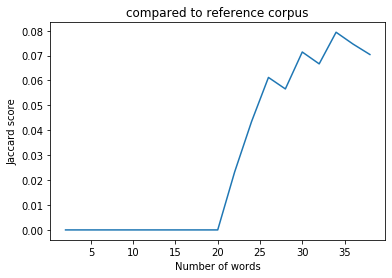

In [173]:
ax = jaccard_scoresb['ratio'].plot(title='compared to reference corpus');
ax.set_xlabel("Number of words")
ax.set_ylabel("Jaccard score")

# for coll

In [177]:
jaccard_scores = nb.frame({'ratio': {x:df_jaccard(coll[coll.small < coll.large], 'ref-small', 'ratio', x) for x in rng},
                            'adjusted': {x:df_jaccard(coll[coll.small < coll.large], 'ref-small', 'adjusted', x) for x in rng},
                           'ref-large': {x:df_jaccard(coll[coll.small < coll.large], 'ref-large', 'ratio', x) for x in rng}
                          }).transpose()

Text(0, 0.5, 'Jaccard score')

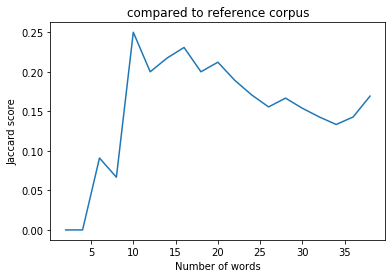

In [175]:
ax = jaccard_scores['ratio'].plot(title='compared to reference corpus');
ax.set_xlabel("Number of words")
ax.set_ylabel("Jaccard score")

Text(0, 0.5, 'Jaccard score')

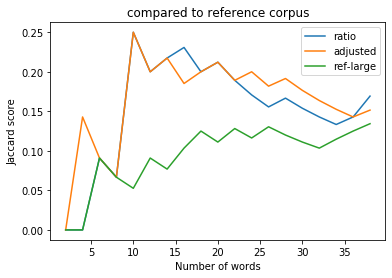

In [178]:
ax = jaccard_scores.plot(title='compared to reference corpus');
ax.set_xlabel("Number of words")
ax.set_ylabel("Jaccard score")

In [29]:
jaccards(collb[collb.small < collb.large].sort_values(by='ratio', ascending = False)[:60].index, collb.sort_values(by='nb', ascending=False)[:100].index)

(22, 138)